# Verbal Categories

In [36]:
from locator import *
from phonstats import agstats
from progress import progress
%matplotlib inline

### Find subsets of Verbal Categories that cover more than 150 languages

In [37]:
loc = Locator(150,include='verbal_categories')
loc.main('discard')

entering 150 17
entering 150 16
entering 150 15
entering 150 14
entering 150 13
entering 150 12
entering 150 11
entering 150 10
entering 150 9
entering 150 8
entering 150 7
entering 150 6
entering 150 5
entering 150 4
entering 150 3
entering 150 2
entering 150 1
checking 0.3K feature groups of length 2
Percent: [##################################################] 100% skipped:0.0K passed: 78
checking 2.7K feature groups of length 3
Percent: [##################################################] 100% skipped:0.0K passed: 138
checking 7.0K feature groups of length 4
Percent: [##################################################] 100% skipped:0.0K passed: 113
checking 7.7K feature groups of length 5
Percent: [##################################################] 100% skipped:0.0K passed: 39
checking 3.3K feature groups of length 6
Percent: [##################################################] 100% skipped:0.0K passed: 8
checking 0.8K feature groups of length 7
Percent: [#########################

### Found 298 Sets -- Sort them by 1st Eigenvalue Proportion

In [38]:
groups = sorted(loc.flagged,key=lambda g: g.quality_index,reverse=True)

### Compute 2 and 4 Cluster Silhouette Scores and Sort by It

In [39]:
for i,g in enumerate(groups):
    g.gen_separation(2)
    g.gen_separation(4)
    progress(i,len(groups),50)

Percent: [##################################################] 100% 

In [40]:
groups.sort(key=lambda g: g.best_silhouette('genetic',4),reverse=True)
groups.sort(key=lambda g: g.best_silhouette('genetic',2),reverse=True)

## Top 5  in Terms of Genetic Separation:

In [41]:
for g in groups[:5]:
    print(g)

3 long group covering 193 languages
in mode PCA:
quality index: 4.06
PC1: 29%
PC2: 23%
fields: 'verbal_categories': 3
features:
79A Suppletion According to Tense and Aspect
79B Suppletion in Imperatives and Hortatives
80A Verbal Number and Suppletion
family1: 25 (Indo-European)
family2: 13 (Afro-Asiatic)
silhouettes:
genetic-2: 0.70 (1 PCs)
genetic-4: 0.22 (1 PCs)


4 long group covering 173 languages
in mode PCA:
quality index: 3.98
PC1: 22%
PC2: 18%
fields: 'verbal_categories': 4
features:
69A Position of Tense-Aspect Affixes
79A Suppletion According to Tense and Aspect
79B Suppletion in Imperatives and Hortatives
80A Verbal Number and Suppletion
family1: 21 (Indo-European)
family2: 11 (Austronesian)
silhouettes:
genetic-2: 0.66 (1 PCs)
genetic-4: 0.15 (1 PCs)


3 long group covering 167 languages
in mode PCA:
quality index: 4.09
PC1: 29%
PC2: 20%
fields: 'verbal_categories': 3
features:
70A The Morphological Imperative
79A Suppletion According to Tense and Aspect
80A Verbal Number a

It seems that 79A and 69A are strong

## Separation Statistics

In [43]:
scores = list()
inds = list()
for g in groups:
    inds.append("-".join(g.cols))
    scores.append({'gen2':g.best_silhouette('genetic',2)[0],'gen4':g.best_silhouette('genetic',4)[0]})
scores = pd.DataFrame(scores,index=inds)
scores.describe()

,gen2,gen4
count,299.000000,299.000000
mean,0.308502,0.017283
std,0.140460,0.062778
min,0.018531,-0.203697
25%,0.210774,-0.021625
50%,0.291453,0.005672
75%,0.395965,0.051460
max,0.700166,0.218670


So the 4-way silhoutte scores are very week. We can use the 75th percentile of the 2-way scores as threshold for the **relatively** good groups

In [44]:
good = [g for g in groups if g.best_silhouette('genetic',2)[0] > 0.38]
loadings = agstats(good)

### Loadings for PC1

In [45]:
loadings.loc['component 1'][['mean_loading','std','participation']].dropna().sort_values(by='mean_loading',ascending=False)

,mean_loading,std,participation
features,,,
77A,0.517823,0.0690694,9
66A,0.511503,0,1
78A,0.478324,0.0700398,11
74A,0.438919,0.107963,20
75A,0.395741,0.084841,31
72A,0.380497,0.362888,12
68A,0.373794,0,1
70A,0.326665,0.210773,35
76A,0.30833,0.158482,24


### Loadings for PC2

In [46]:
loadings.loc['component 2'][['mean_loading','std','participation']].dropna().sort_values(by='mean_loading',ascending=False)

,mean_loading,std,participation
features,,,
79A,0.485382,0.298206,34
68A,0.48404,0,1
72A,0.454502,0.330772,12
75A,0.411725,0.215895,31
71A,0.385628,0.27556,26
76A,0.298965,0.270613,24
69A,0.237793,0.218982,48
79B,0.203741,0.179913,21
70A,0.191069,0.134527,35


So 77A and 66A lead PC1 while 79A and 68A lead PC2

## But there's another check that can be done:
Direct check -- what is the average silhoutte score for groups that a feature participates in

In [47]:
areas = yaml.load(open('wals-areas.yml'))
stats = list()
ind = list()
for f in areas['verbal_categories']:
    part = [g for g in groups if f in g.cols]
    g2 = np.array([g.best_silhouette('genetic',2)[0] for g in part])
    g4 = np.array([g.best_silhouette('genetic',4)[0] for g in part])
    stats.append({
        'gen2 mean': g2.mean(),
        'gen2 std' : g2.std(), 
        'gen4 mean':g4.mean(),
        'gen4 std': g4.std()
    })
    ind.append("{:s} ({:d})".format(f,len(part)))
stats = pd.DataFrame(stats,index=ind)

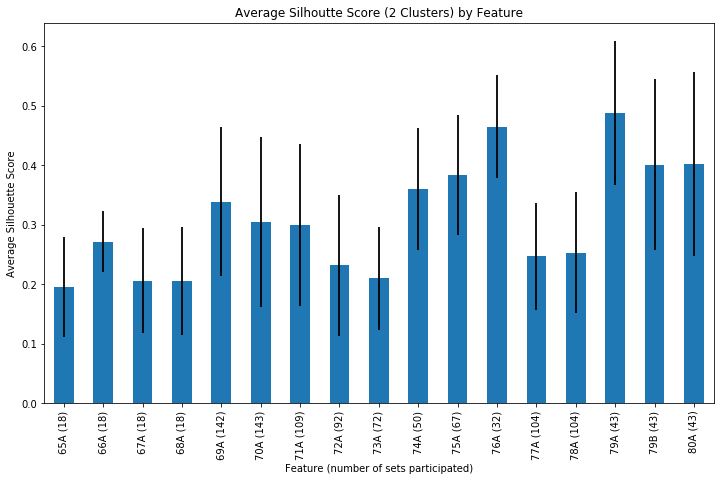

In [48]:
fig,ax = plt.subplots(figsize=(12,7))
ax.set_title('Average Silhoutte Score (2 Clusters) by Feature')
ax.set_ylabel('Average Silhouette Score')
ax.set_xlabel('Feature (number of sets participated)')
stats['gen2 mean'].plot.bar(yerr=stats['gen2 std'],figsize=(12,7),ax=ax)

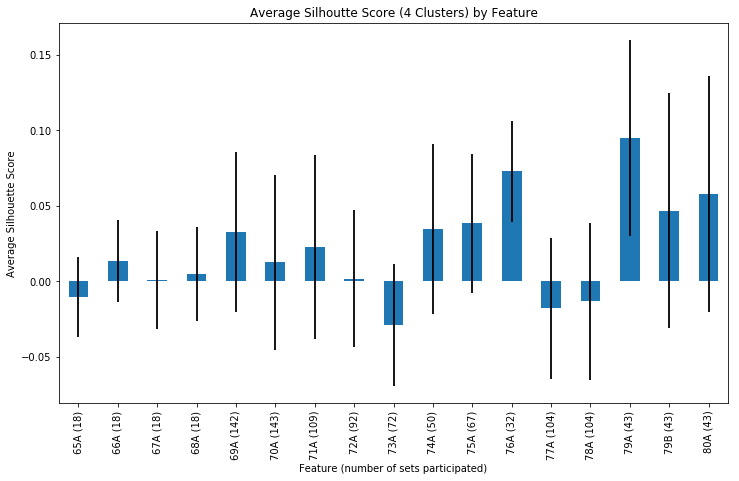

In [49]:
fig,ax = plt.subplots(figsize=(12,7))
ax.set_title('Average Silhoutte Score (4 Clusters) by Feature')
ax.set_ylabel('Average Silhouette Score')
ax.set_xlabel('Feature (number of sets participated)')
stats['gen4 mean'].plot.bar(yerr=stats['gen4 std'],figsize=(12,7),ax=ax)

### By this Method, the strong featues are 79A and 76A

Be that as it may, the two strong groups look like this:

In [50]:
print(groups[0])

3 long group covering 193 languages
in mode PCA:
quality index: 4.06
PC1: 29%
PC2: 23%
fields: 'verbal_categories': 3
features:
79A Suppletion According to Tense and Aspect
79B Suppletion in Imperatives and Hortatives
80A Verbal Number and Suppletion
family1: 25 (Indo-European)
family2: 13 (Afro-Asiatic)
silhouettes:
genetic-2: 0.70 (1 PCs)
genetic-4: 0.22 (1 PCs)




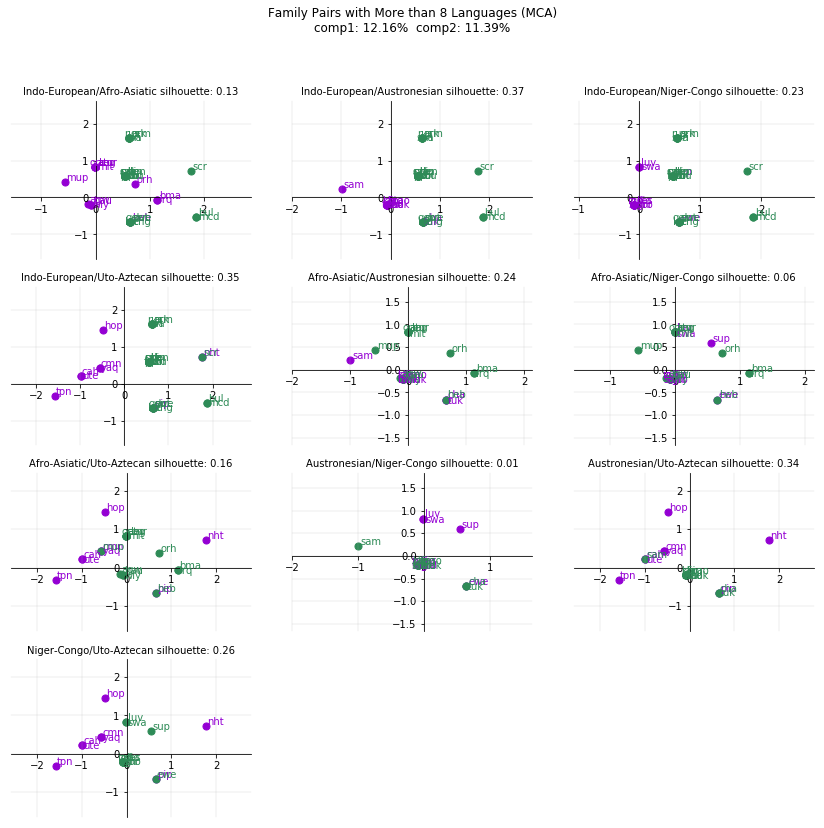

In [51]:
groups[0].mode = 'mca'
groups[0].plot_multifam()

In [52]:
print(groups[1])

4 long group covering 173 languages
in mode PCA:
quality index: 3.98
PC1: 22%
PC2: 18%
fields: 'verbal_categories': 4
features:
69A Position of Tense-Aspect Affixes
79A Suppletion According to Tense and Aspect
79B Suppletion in Imperatives and Hortatives
80A Verbal Number and Suppletion
family1: 21 (Indo-European)
family2: 11 (Austronesian)
silhouettes:
genetic-2: 0.66 (1 PCs)
genetic-4: 0.15 (1 PCs)




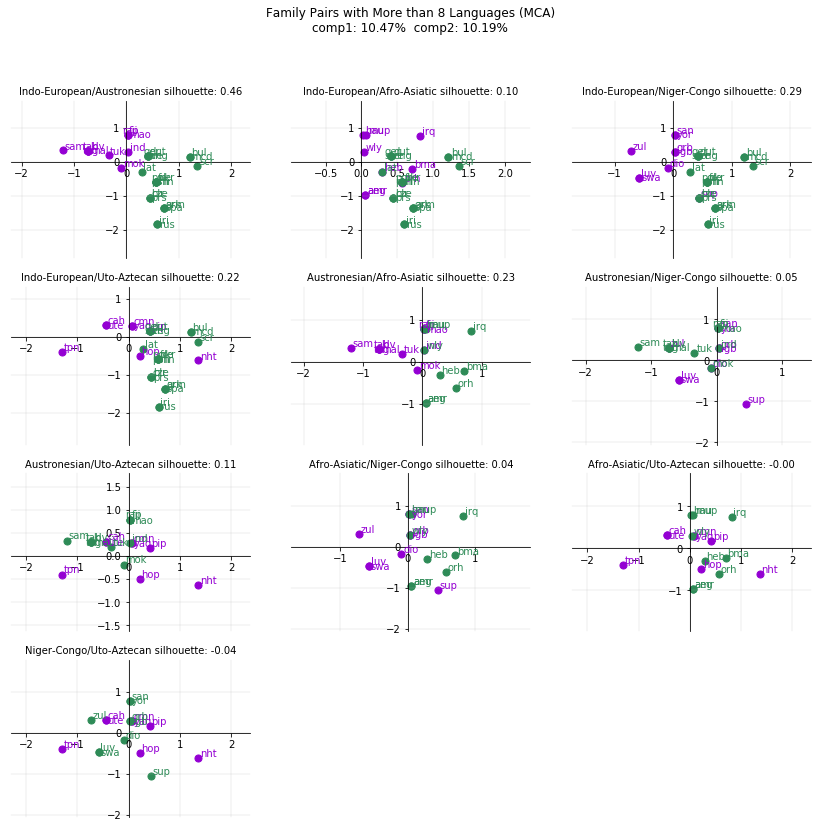

In [53]:
groups[1].mode = 'mca'
groups[1].plot_multifam()